In [1]:

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# DATA FILES

price_files = ["bittensor_token_price.csv", "fetchai_token_price.csv",
               "numerai_token_price.csv", "oceanprotocol_token_price.csv",
               "oraichain_token_price.csv", "singularitynet_token_price.csv"]

commits_mapping = {
    "bittensor_commits.json": "TAO",
    "fetchai_commits.json": "FET",
    "numerai_commits.json": "NMR", 
    "oceanprotocol_commits.json": "OCEAN",
    "oraichain_commits.json": "ORAI",
    "singularitynet_commits.json": "AGIX"
}

issues_mapping = {
    "bittensor_issues.json": "TAO",
    "fetchai_issues.json": "FET",
    "numerai_issues.json": "NMR", 
    "oceanprotocol_issues.json": "OCEAN",
    "oraichain_issues.json": "ORAI",
    "singularitynet_issues.json": "AGIX"
}

repos_mapping = {
    "bittensor_repos.json": "TAO",
    "fetchai_repos.json": "FET",
    "numerai_repos.json": "NMR", 
    "oceanprotocol_repos.json": "OCEAN",
    "oraichain_repos.json": "ORAI",
    "singularitynet_repos.json": "AGIX"
}

tokens = ["TAO", "FET", "NMR",
          "OCEAN", "ORAI", "AGIX"]



In [3]:
def get_commits(token, mapping):
    for k, v in mapping.items():
        if token == v:
            filename = f'github_data/{k}'
            with open(filename) as commits_file:
                parsed_json = json.load(commits_file)
            
            commits_rows = [row for sublist in parsed_json for row in sublist]
            commits_df = pd.DataFrame(commits_rows)
            return commits_df
    return f'No commit data for token {token}'

def get_repos(token, mapping):
    for k, v in mapping.items():
        if token == v:
            filename = f'github_data/{k}'
            with open(filename) as repos_file:
                parsed_json = json.load(repos_file)
            
            repos_rows = [row for row in parsed_json]
            repo_df = pd.DataFrame(repos_rows)
            return repo_df
    return f'No repo data for token {token}'

In [92]:
# IDEA: CALL GET_TRENDS, RETURN WEEK, MONTH AND YEAR, THEN CONCAT ALL DFS AND PLOT ITERATING TOKENS LIST
def get_commit_trends(commits_df):
    flat_commit = pd.json_normalize(commits_df['commit'])
    commits_df = pd.concat([commits_df, flat_commit], axis=1)
    commits_df.drop(columns=['commit'], inplace=True)

    commits_df['author.date'] = pd.to_datetime(commits_df['author.date']).dt.date

    date_counts = pd.DataFrame()

    date_counts['count'] = commits_df['author.date'].value_counts()
    
    # Reset index to make the date a column
    date_counts = date_counts.reset_index()
    date_counts.columns = ['date', 'count']

    # Convert 'date' column to datetime
    date_counts['date'] = pd.to_datetime(date_counts['date'])
    date_counts['year'] = pd.to_datetime(date_counts['date']).dt.year

    # Set 'date' column as the index
    date_counts.set_index('date', inplace=True)

    # Resample into monthly and quarterly intervals
    yearly_counts = date_counts.resample('Y').sum()
    monthly_counts = date_counts.resample('M').sum()
    weekly_counts = date_counts.resample('w').sum()

    return yearly_counts, monthly_counts, weekly_counts

def get_repos_trends(repos_df):
    repos_df['created_at'] = pd.to_datetime(repos_df['created_at']).dt.date
    # Create a new DataFrame to store the counts for each date
    date_counts = pd.DataFrame()

    # Count the occurrences of dates in each column separately
    date_counts['count'] = repos_df['created_at'].value_counts()  

    # Reset index to make the date a column
    date_counts = date_counts.reset_index()

    # Rename the columns for clarity
    date_counts.columns = ['date', 'count']

    # Convert 'date' column to datetime
    date_counts['date'] = pd.to_datetime(date_counts['date'])
    date_counts['year'] = pd.to_datetime(date_counts['date']).dt.year
    date_counts['week'] = pd.to_datetime(date_counts['date']).dt.week

    # Set 'date' column as the index
    date_counts.set_index('date', inplace=True)

    # Resample into monthly and quarterly intervals
    yearly_counts = date_counts.resample('Y').sum()
    monthly_counts = date_counts.resample('M').sum()
    quarterly_counts = date_counts.resample('w').sum()

    return yearly_counts, monthly_counts, quarterly_counts

def preprocess_trends(repo_df, token):

    repo_rank = pd.DataFrame()
    repo_rank['date'] = repo_df.index
    repo_rank['year'] = repo_df.index.year
    repo_rank['week'] = repo_df.index.week
    repo_rank['total'] = repo_df['count'].cumsum().values
    repo_rank['project'] = token

    return repo_rank


def plot_evolution_graph(rank_df, time_frame, types):
    
    # Rank projects based on the total for each date
    rank_df['rank'] = rank_df.groupby('date')['total'].rank(method='first', ascending=False)

    # Pivot the data to get the rank evolution for each project
    rank_evolution = rank_df.pivot(index='date', columns='project', values='rank')

    # Plot the evolution of project rankings over time
    plt.figure(figsize=(12, 8))
    for project in rank_evolution.columns:
        plt.plot(rank_evolution.index, rank_evolution[project], marker='o', label=project)

    plt.ylim(0.5, len(rank_evolution.columns)+2)  # Set y-axis limits to the number of projects
    plt.gca().invert_yaxis()  # Invert y-axis to show rank 1 at the top
    plt.xlabel('Date')
    plt.ylabel('Rank')
    plt.title(f'{time_frame} Evolution of Project Rankings Based on Cumulative {types}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


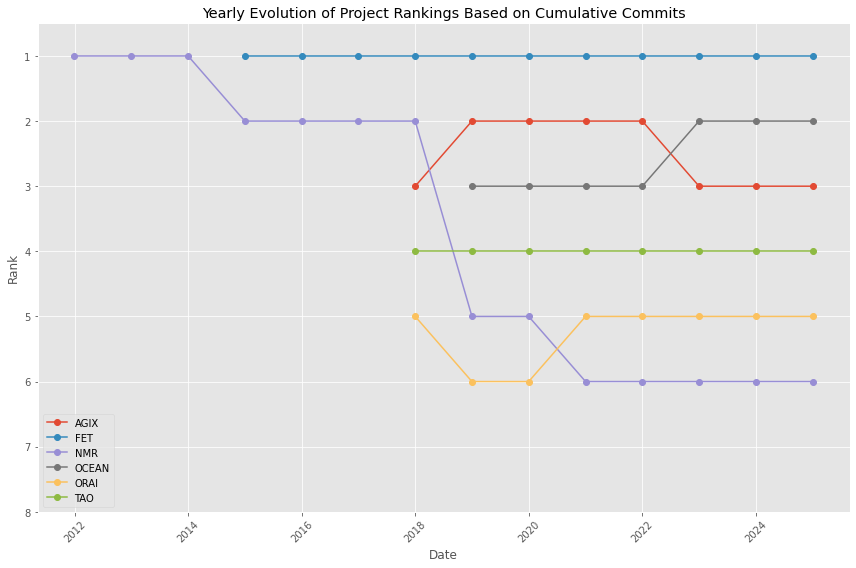

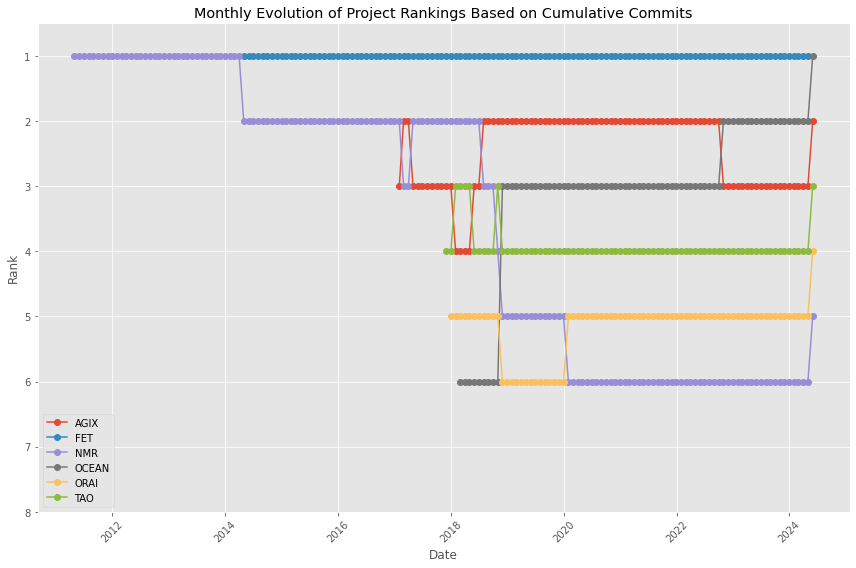

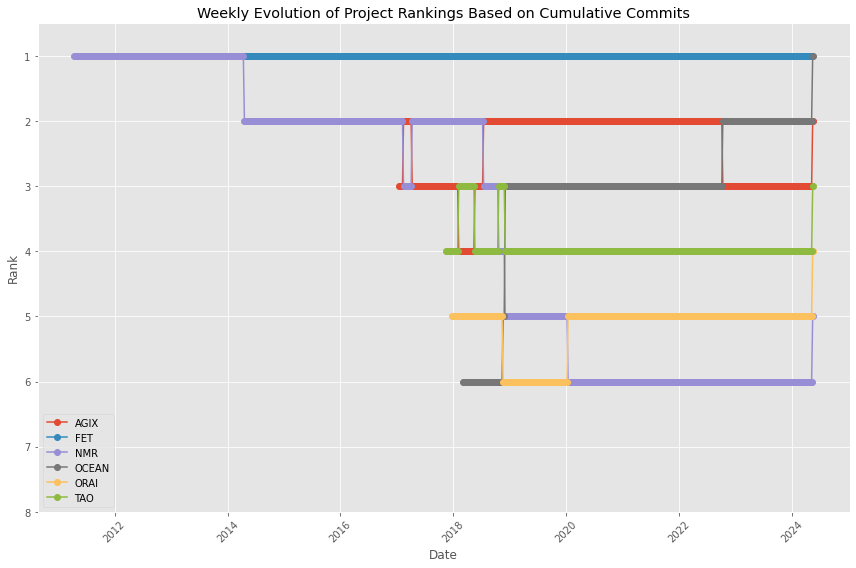

In [93]:
## EVOLUTION BASED ON COMMITS
rank_commit_year = pd.DataFrame(columns=['date', 'year', 'week', 'total', 'project'])
rank_commit_month = pd.DataFrame(columns=['date', 'year', 'week', 'total', 'project'])
rank_commit_week = pd.DataFrame(columns=['date', 'year', 'week', 'total', 'project'])



for i, token in enumerate(tokens):
    commits_data = get_commits(token, commits_mapping)
    year_commit_trend, month_commit_trend, week_commit_trend = get_commit_trends(commits_data)
    year_commit_rank = preprocess_trends(year_commit_trend, token)
    month_commit_rank = preprocess_trends(month_commit_trend, token)
    week_commit_trend = preprocess_trends(week_commit_trend, token)

    rank_commit_year = pd.concat([rank_commit_year, year_commit_rank])
    rank_commit_month = pd.concat([rank_commit_month, month_commit_rank])
    rank_commit_week = pd.concat([rank_commit_week, week_commit_trend])

plot_evolution_graph(rank_commit_year, 'Yearly', 'Commits')

plot_evolution_graph(rank_commit_month, 'Monthly', 'Commits')

plot_evolution_graph(rank_commit_week, 'Weekly', 'Commits')

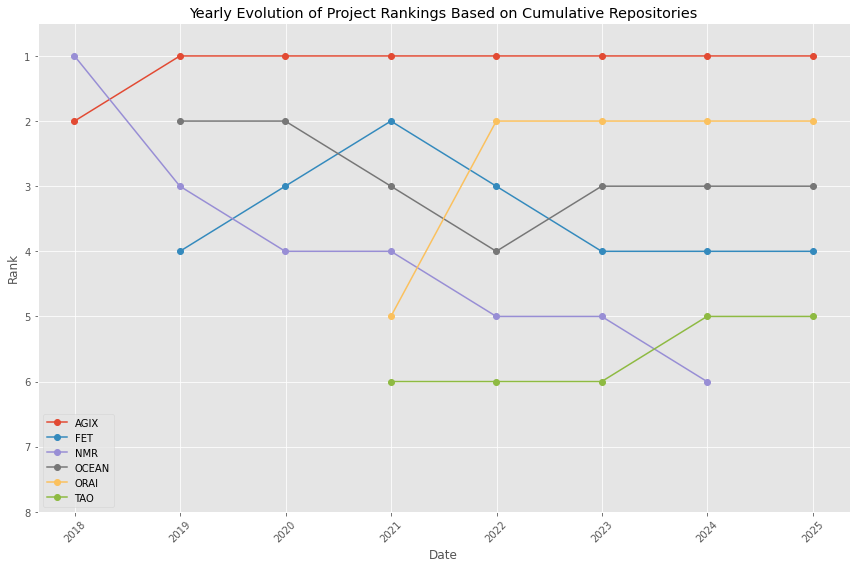

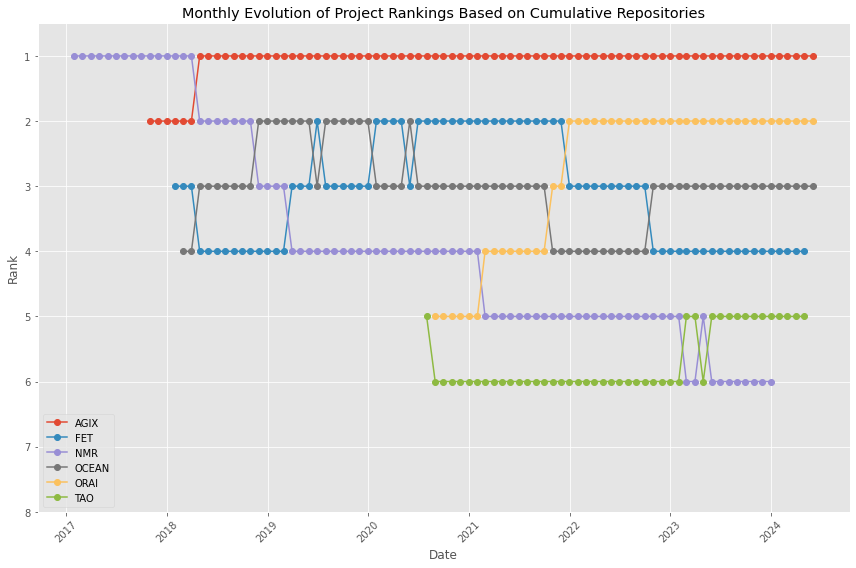

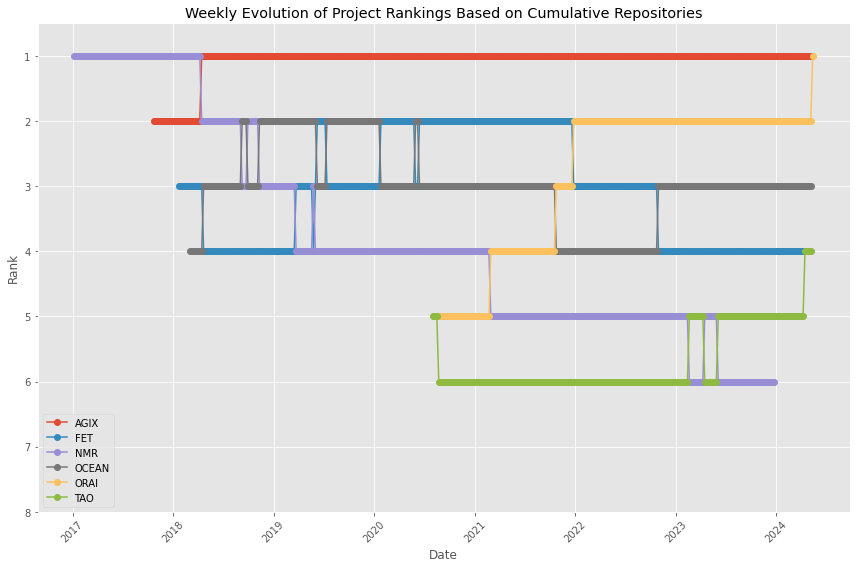

In [94]:
## EVOLUTION BASED ON REPOSITORIES
rank_repo_year = pd.DataFrame(columns=['date', 'year', 'week', 'total', 'project'])
rank_repo_month = pd.DataFrame(columns=['date', 'year', 'week', 'total', 'project'])
rank_repo_week = pd.DataFrame(columns=['date', 'year', 'week', 'total', 'project'])



for i, token in enumerate(tokens):
    repos_data = get_repos(token, repos_mapping)
    year_repo_trend, month_repo_trend, week_repo_trend = get_repos_trends(repos_data)
    year_repo_rank = preprocess_trends(year_repo_trend, token)
    month_repo_rank = preprocess_trends(month_repo_trend, token)
    week_repo_trend = preprocess_trends(week_repo_trend, token)

    rank_repo_year = pd.concat([rank_repo_year, year_repo_rank])
    rank_repo_month = pd.concat([rank_repo_month, month_repo_rank])
    rank_repo_week = pd.concat([rank_repo_week, week_repo_trend])


plot_evolution_graph(rank_repo_year, 'Yearly', 'Repositories')

plot_evolution_graph(rank_repo_month, 'Monthly', 'Repositories')

plot_evolution_graph(rank_repo_week, 'Weekly', 'Repositories')